In [2]:
import pandas as pd

import os

os.environ["OMP_NUM_THREADS"] = "2"
os.environ["OPENBLAS_NUM_THREADS"] = "2"
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
os.environ["NUMEXPR_NUM_THREADS"] = "2"



import pandas as pd

# Load and combine datasets (as before)
datasets = {
    'benign': pd.read_csv('labeled_dataset_benign.csv'),
    'dns': pd.read_csv('labeled_dataset_DNS_Spoofing.csv'),
    'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')
}
combined_df = pd.concat([datasets['benign'], datasets['dns'], datasets['mitm']], ignore_index=True)
combined_df = combined_df.drop('dst_mac', axis=1)

print(combined_df.shape)

C:\Users\nazih\AppData\Local\Temp\ipykernel_9720\1938280762.py:18: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'dns': pd.read_csv('labeled_dataset_DNS_Spoofing.csv'),
C:\Users\nazih\AppData\Local\Temp\ipykernel_9720\1938280762.py:19: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  'mitm': pd.read_csv('labeled_dataset_MITM_ArpSpoofing.csv')


(883525, 135)


In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def is_hex_mac(mac):
    if pd.isna(mac) or mac == 'unknown':
        return False
    pattern = r'^([0-9A-Fa-f]{2}[:-]){5}([0-9A-Fa-f]{2})$'
    return bool(re.match(pattern, str(mac)))


combined_df = combined_df[~combined_df['src_mac'].apply(is_hex_mac)]

# Drop duplicates
print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")
combined_df = combined_df.drop_duplicates()
print(f"New shape after removing duplicates: {combined_df.shape}")

# Identify categorical columns
categorical_cols = [col for col in combined_df.columns if combined_df[col].nunique() < 10 or combined_df[col].dtype == 'object']
print(f"Categorical features: {categorical_cols}")

for col in categorical_cols:
    combined_df[col] = combined_df[col].astype(str).fillna('unknown')

numerical_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    combined_df[col] = combined_df[col].fillna(combined_df[col].median())

X = combined_df.drop(['Label', 'src_mac'], axis=1, errors='ignore')
y_attack = combined_df['Label']
y_device = combined_df['src_mac']

# Encode device labels
le_device = LabelEncoder()
y_device_encoded = le_device.fit_transform(y_device)

from sklearn.preprocessing import MultiLabelBinarizer


combined_df['All_Labels'] = combined_df.apply(
    lambda row: [row['Label'], row['src_mac']], axis=1
)

mlb = MultiLabelBinarizer()
Y_multilabel = mlb.fit_transform(combined_df['All_Labels'])

multilabel_class_names = mlb.classes_


X_numeric = X.select_dtypes(include=['number'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)




X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled,       
    Y_multilabel,       
    test_size=0.2, 
    random_state=42
)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)



Number of duplicate rows: 0
New shape after removing duplicates: (432555, 135)
Categorical features: ['src_mac', 'src_ip', 'dst_ip', 'port_class_dst', 'l4_tcp', 'l4_udp', 'ttl', 'handshake_version', 'handshake_ciphersuites', 'tls_server', 'http_request_method', 'http_host', 'http_response_code', 'user_agent', 'dns_server', 'dns_query_type', 'dns_len_ans', 'device_mac', 'eth_src_oui', 'eth_dst_oui', 'highest_layer', 'http_uri', 'http_content_len', 'http_content_type', 'icmp_type', 'icmp_checksum_status', 'icmp_data_size', 'Label']


C:\Users\nazih\AppData\Local\Temp\ipykernel_9720\734139780.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['All_Labels'] = combined_df.apply(


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, jaccard_score, classification_report
from sklearn.base import clone

xgb_rfe_estimator = XGBClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42, 
    n_jobs=-1,
    eval_metric='logloss'
)


TARGET_FEATURES = 50 
rfe_selector = RFE(
    estimator=xgb_rfe_estimator, 
    n_features_to_select=TARGET_FEATURES, 
    step=5,
    verbose=1
)

print(f"Starting RFE to select {TARGET_FEATURES} features...")
Y_single_label = Y_train[:, 0]
rfe_selector.fit(X_train, Y_single_label)


selected_features = X_train.columns[rfe_selector.support_]

X_train_RFE = X_train[selected_features]
X_test_RFE = X_test[selected_features]

print(f"RFE complete. Using {len(selected_features)} features.")
print(f"Selected features: {selected_features.tolist()[:5]}... (first 5 shown)")


try:
    multilabel_class_names = mlb.classes_
except NameError:
    multilabel_class_names = [f"Label_{i+1}" for i in range(Y_train.shape[1])]


print("\n--- Training Multi-Label XGBoost (Weighted) on RFE Features ---")

xgb_base = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    n_jobs=1,
    max_depth=8,
    reg_alpha=0.5, 
    reg_lambda=3 
)

num_outputs = Y_train.shape[1]
fitted_xgb_estimators = [] 

print("Fitting individual XGBoost models with custom scale_pos_weight...")

for i in range(num_outputs):
    y_col = Y_train[:, i]
    
    pos_count = np.sum(y_col == 1)
    neg_count = np.sum(y_col == 0)
    weight = neg_count / pos_count if pos_count > 0 else 1.0
    
    xgb_estimator = clone(xgb_base).set_params(scale_pos_weight=weight)
    
    xgb_estimator.fit(X_train_RFE, y_col)
    
    fitted_xgb_estimators.append(xgb_estimator)

Y_pred_xgb = np.zeros_like(Y_test)

for i, estimator in enumerate(fitted_xgb_estimators):
    Y_pred_xgb[:, i] = estimator.predict(X_test_RFE)


subset_acc = accuracy_score(Y_test, Y_pred_xgb)
jaccard = jaccard_score(Y_test, Y_pred_xgb, average='samples', zero_division=0)

print("FINAL WEIGHTED XGBOOST (RFE FEATURES) TEST SET RESULTS")
print("="*70)
print(f"Subset Accuracy (Exact Match): {subset_acc:.4f}")
print(f"Jaccard Score (Label Similarity): {jaccard:.4f}")

print("MULTI-LABEL CLASSIFICATION REPORT")

report = classification_report(
    Y_test, 
    Y_pred_xgb, 
    target_names=multilabel_class_names, 
    zero_division=0,
    output_dict=False
)
print(report)

Starting RFE to select 50 features...
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
RFE complete. Using 50 features.
Selected features: [0, 1, 2, 3, 6]... (first 5 shown)

--- Training Multi-Label XGBoost (Weighted) on RFE Features ---
Fitting individual XGBoost models with custom scale_pos_weight...


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC 
from sklearn.metrics import accuracy_score, jaccard_score, classification_report
from sklearn.base import clone
from sklearn.multioutput import MultiOutputClassifier
import catboost as cb


try:
    multilabel_class_names = mlb.classes_
except NameError:
    multilabel_class_names = [f"Label_{i+1}" for i in range(Y_train.shape[1])]

model_configs_optimized = {
    'RandomForest': {
        'base_estimator': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    },
    'LogisticRegression': {
        'base_estimator': LogisticRegression(solver='liblinear', random_state=42,class_weight='balanced'),
    },
    'LinearSVC': {
        'base_estimator': LinearSVC(random_state=42, class_weight='balanced', dual=True, multi_class='ovr', max_iter=500),
    },
    'AdaBoost': {
        'base_estimator': AdaBoostClassifier(n_estimators=100, random_state=42, estimator=XGBClassifier(n_estimators=10, max_depth=3, random_state=42)),
    },
    'CatBoost': {
        'base_estimator': cb.CatBoostClassifier(iterations=100, random_state=42, verbose=0, thread_count=1, auto_class_weights='Balanced', loss_function='Logloss'),
    }
}

results = {}
print("\n--- Multi-Label Model Comparison (Parallel Fit via MultiOutputClassifier) ---")

for model_name, config in model_configs_optimized.items():
    print(f"\n--- Training {model_name} (Parallel Fit) ---")
    
    base_estimator = config['base_estimator']
    
    multi_model = MultiOutputClassifier(base_estimator, n_jobs=-1)
    
    multi_model.fit(X_train_RFE, Y_train) 
    
    Y_pred = multi_model.predict(X_test_RFE)
    
    subset_acc = accuracy_score(Y_test, Y_pred)
    jaccard = jaccard_score(Y_test, Y_pred, average='samples', zero_division=0)
    
    results[model_name] = {'subset_accuracy': subset_acc, 'jaccard_score': jaccard}
    
    print(f"[{model_name}] Subset Accuracy: {subset_acc:.4f}")
    print(f"[{model_name}] Jaccard Score: {jaccard:.4f}")


print("\n" + "=" * 70)
print("MULTI-LABEL MODEL SUMMARY (Parallel Weighted Fit)")
print("=" * 70)
print(f"{'Model':<20} | {'Subset Accuracy':<18} | {'Jaccard Score':<15}")
print("-" * 55)

for model_name, metrics in results.items():
    print(f"{model_name:<20} | {metrics['subset_accuracy']:.4f}{'':<17} | {metrics['jaccard_score']:.4f}")

Starting RFE to select 50 features...


KeyboardInterrupt: 

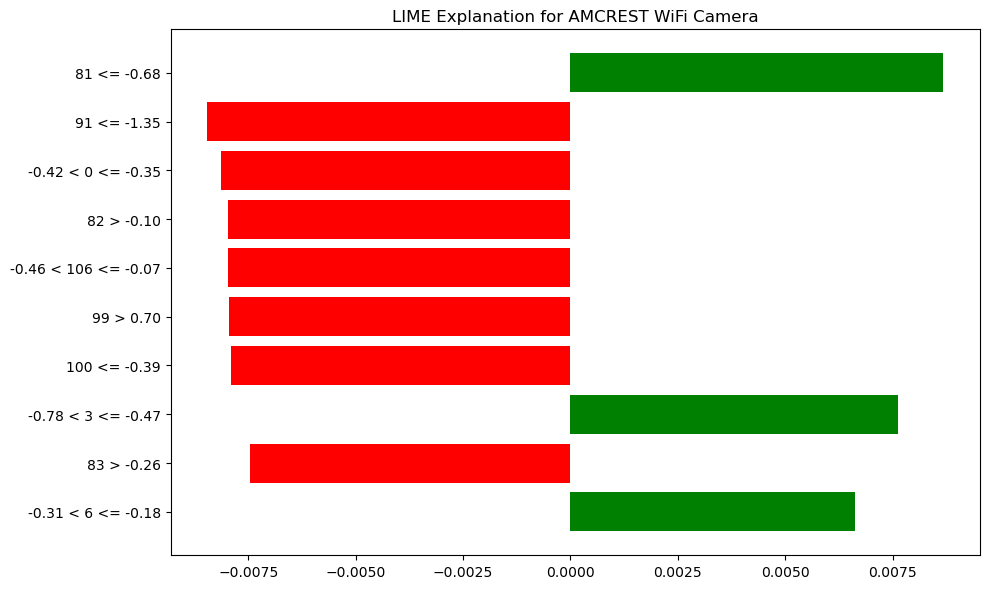

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

label_idx_to_explain = 0  
model_to_explain = fitted_xgb_estimators[label_idx_to_explain]

feature_names = selected_features.tolist()

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_RFE),
    mode='classification',
    feature_names=feature_names,
    categorical_features=[],
    verbose=False,
    class_names=['Negative', 'Positive'],  
    discretize_continuous=True
)

instance_idx = 5
instance = X_test_RFE.iloc[instance_idx].values.reshape(1, -1)

exp = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=lambda x: model_to_explain.predict_proba(x),
    num_features=10,
    num_samples=1000
)

fig = exp.as_pyplot_figure(label=1)
fig.set_size_inches(10, 6)

plt.title(f'LIME Explanation for {multilabel_class_names[label_idx_to_explain]}')
plt.tight_layout()
plt.savefig(f"lime_explanation_{multilabel_class_names[label_idx_to_explain]}.png", dpi=300)
plt.show()
